# Aufgabe 3: Bag-of-Features und KNN

Im Rahmen des Bag-of-Features Ansatzes werden Statistiken über auftretende visuelle Wörter genutzt, um Bilder zu repräsentieren. Diese Repräsentation wird anschließend genutzt, um mit Hilfe eines k-Nächste-Nachbar Klassifikators Bilder auf Basis des Trainingsdatensatzes zu klassifizieren. Hierfür berechnen Sie im Rahmen dieser Aufgabe zunächst SIFT-Deskriptoren für alle Bilder des STL10 Trainingsdatensatzes. Diese werden dann im Rahmen einer Clusteranalyse zur Erstellung eines Codebuchs genutzt. Anschließend wird für jedes Bild im Trainings und Test Split eine Bag-of-Features Repräsentation berechnet. Zur Lösung von Zweiklassenproblemen soll anschließend ein kNN implementiert werden.

# STL10 Datensatz

In [1]:
# Verwednung von matplotlib inline oder widget
%matplotlib inline

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from common.visualization import draw_confusion_mat

path = '/data/torchvision'

train_ds = datasets.STL10(root=path,
                          split='train',
                          transform=transforms.ToTensor(),
                         download = True)

test_ds = datasets.STL10(root=path,
                         split='test',
                         transform=transforms.ToTensor(),
                        download = True)

labels = train_ds.labels
classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
class_id_dict = dict(zip(classes, range(10)))

Files already downloaded and verified
Files already downloaded and verified


# SIFT Deskriptoren

Der SIFT Deskriptor ähnelt in seinem Aufbau und in seiner Struktur stark dem von ihnen implementierten Bilddeskriptor. Im Rahmen dieser Aufgabe greifen wir aus Gründen der Effizienz auf die von OpenCV bereit gestellten Funktionen zur Berechnung von SIFT Deskriptoren zurück. Die extrahierten Deskriptoren werden im Wesentlichen durch die Größe der Deskriptorzellen, ihrer Anzahl und der Schrittweite im regulären Gitter bestimmt. Vervollständigen sie die entsprechenden Variablen ausgehend von einer Zellengröße von 4 Pixeln, sowie einer Breite beziehungsweise Höhe von 4 Zellen pro Deskriptor. Geben Sie die Schrittweite in Abhängigkeit von der Deskriptorgröße (Größe des Analyseausschnitts für einen Deskriptor) an, wobei Sie zunächst von einer Schrittweite von einem halben Deskriptor ausgehen können. Nutzen Sie für die Berechnung der SIFT Deskriptoren für ein Bild die Funktion `compute_sift_descriptors` im Modul `common.descriptor`.

Berechnen Sie nun für alle Trainingsbilder entsprechende SIFT Deskriptoren. Folgende Variablen werden weiterhin benötigt:
* `desc_pro_img`: int, Anzahl der Deskriptoren pro Bild
* `train_labels`: list (Anzahl des Trainingsbeispiele), enthält für jedes Beispiel des Trainingsdatensatzes die Klasse des Ursprungsbilds
* `train_features`: ndarray, SIFT Deskriptoren für den gesamten Trainingsdatensatz (Anzahl der Deskriptoren x 128)

**Hinweise:**
- Der `DataLoader` erlaubt das Iterieren über den gesamten Datensatz
- Der Dataloader Batches (Stapel) von Bildern und zugehörigen Labels zurück. In diesem Beispiel ist zwar immer nur ein Bild enthalten, es gibt aber trotzdem eine weitere Dimension. Verwenden Sie daher `img[0]` um das RGB Bild zu erhalten.
- Beachten Sie, dass der Dataloader die Bilder normiert auf den Wertebereich [0, 1] und als RGB ausgibt. Die Funktion `compute_sift_descriptors` erwartet jedoch ein Grauwert-Bild im Wertebericht von [0, 255] vom Typ `uint8`. 
- Die richtige Sortierung der Bild Dimensionen kann mit
[transpose](
https://numpy.org/doc/stable/reference/generated/numpy.transpose.html) vorgenommen werden.
- FÜr eine Änderung des Wertebereichs und Normalisierung der Bilder kann auf open cv zurückgegeriffen werden [cv2.normalize](https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga87eef7ee3970f86906d69a92cbf064bd)
- Um du trainingsmerkmale zu stacken könnte Ihnen [vstack](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html) helfen

In [2]:
import cv2
import numpy as np
import tqdm
from common.descriptor import compute_sift_descriptors
from torch.utils.data import DataLoader

"""
transpose
https://numpy.org/doc/stable/reference/generated/numpy.transpose.html
vstack
https://numpy.org/doc/stable/reference/generated/numpy.vstack.html
cv2.normalize
https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga87eef7ee3970f86906d69a92cbf064bd
"""

# Groesse der Zellen
cell_size = 4

# Groesse des Analyseausschnitts (horizontal und vertikal) pro Deskriptor
desc_size = cell_size * 4

# Schrittweite, um die das Analysefenster auf dem Bild verschoben wird, um den naechsten Deskriptor zu berechnen.
step_size = int(desc_size * 0.5)

train_labels =[]
features=[]
trainloader = DataLoader(train_ds)
for img, label in tqdm.tqdm(trainloader):
    
    train_labels.append(label) 
    img1=img[0]
    img1=np.array(img1).transpose((1,2,0))
    image8bit = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8') 
    _,feature=compute_sift_descriptors(image8bit,cell_size,step_size)
    features.append(feature)

train_features = np.vstack(features)
desc_pro_img = train_features.shape[0]//len(trainloader)
print('Anzahl der SIFT Descriptors pro Bild: {}'.format(desc_pro_img))

100%|██████████| 5000/5000 [00:07<00:00, 706.25it/s]


Anzahl der SIFT Descriptors pro Bild: 121


# Clustering zur Erstellung des Codebuchs

Die berechneten Deskriptoren werden nun zur Bestimmung des Codebuchs genutzt, welches wiederum als Grundlage zur Berechnung der Bag-of-Features Vektoren dient. Nutzen Sie zunächst die Funktion `kmeans2`, um die Zentroiden des Codebuchs zu berechnen. Darüber hinaus gibt die Funktion ihnen auch direkt die Abbildung der Trainingsdeskriptoren auf die entsprechenden Cluster IDs zurück. Nutzen Sie diese um eine Bag-of-Features Repräsentation zu berechnen. Dies lässt sich wie folgt realisieren:
* Erzeugen Sie eine Liste `vw_list` (ndarray), welche die Indizes der zu den Deskriptoren korrespondierenden Visual Words enthält, indem sie diese mit kmeans clustern.
* Wandeln sie diese Liste um in `vw_mat` ndarray (Anzahl der Trainingsbeispiele x desc_pro_img), wobei jede Reihe ein Bild repräsentiert. Jedes Bild ist vollständig über die zuordnung zu den Visual Words beschrieben
* Erzeugen Sie `train_bof_mat` ndarray (Anzahl der Trainingsbeispiele x vw_count). Hierzu erstellen Sie für jedes Bild (eine Reihe in der vw_mat) ein Histogramm über die Cluster IDs (die visual words). Daraus resultiert wiederum ein Array in dem jede Reihe den Bag-of-Features Vektor für das Bild enthält.

**Tipp:** Mit der Funktion [`np.bincount`](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html) lassen sich Histogramme über Numpy Arrays berechnen. Verwenden Sie dabei auch das Argument `minlength`!

/opt/conda/lib/python3.9/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


(5000, 128)


"\nplt.figure(figsize=(20,5))\nplt.xlim((0,200))\nx_pos = np.arange(vw_count)\ni= 0 \nbarlist =[]\nwhile  i< len(list_bars)  : \n    barlist.append(plt.bar(x_pos, list_bars[i], width=0.9, align='center', alpha=1))\nfor count in range ( len(barlist))  :\n    for label, bar in enumerate(barlist[count]):\n        color = color_map[label % 8]\n        bar.set_color(color)\n"

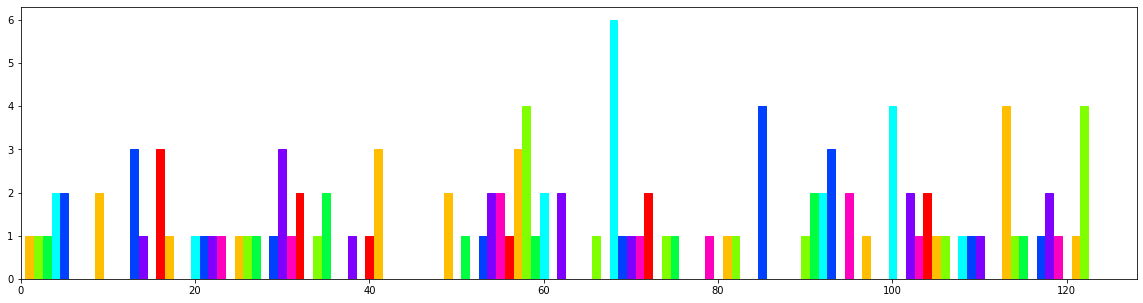

In [3]:
from scipy.cluster.vq import kmeans2
import matplotlib
import matplotlib.pyplot  as plt
vw_count = 128

k_means_iter=20
centroids, vw_list = kmeans2(train_features,vw_count,iter=k_means_iter)

#print ( len(train_ds))  ## gives back the number of training beispiel 

vw_mat = vw_list.reshape(len(train_ds) ,desc_pro_img) 

#train_bof_mat  = np.zeros((len(train_ds) , vw_count )) 

#list_bars= [] # for ploting  

hist = []
for img in  range (  vw_mat.shape[0] )  : 
   # list_bars.append(np.bincount( vw_mat[0  ,  : ] , minlength =vw_count ))
      hist.append ( np.bincount( vw_mat[img ] , minlength =vw_count ))

train_bof_mat = np.vstack(hist)    

print(train_bof_mat.shape) 


#plot one vector of bag feature to see what s happening 

color_map = [matplotlib.colors.hsv_to_rgb((i/8, 1, 1)) for i in range(8)]
plt.figure(figsize=(20,5))
plt.xlim((0,vw_count))
x_pos = np.arange(vw_count)
barlist =plt.bar(x_pos, train_bof_mat[0 , : ], width=0.9, align='center', alpha=1)
for label, bar in enumerate(barlist):
        color = color_map[label % 8]
        bar.set_color(color)

#code to plot all features 

'''
plt.figure(figsize=(20,5))
plt.xlim((0,200))
x_pos = np.arange(vw_count)
i= 0 
barlist =[]
while  i< len(list_bars)  : 
    barlist.append(plt.bar(x_pos, list_bars[i], width=0.9, align='center', alpha=1))
for count in range ( len(barlist))  :
    for label, bar in enumerate(barlist[count]):
        color = color_map[label % 8]
        bar.set_color(color)
'''

# Berechnen der BoF-Vektoren für die Testbilder

Als nächstes sollen die Bag-of-Features Vektoren für die Testbilder berechnet werden. Gehen Sie dazu wie folgt vor. Extrahieren Sie zunächst alle SIFT-Deskriptoren und speichern Sie diese in einem Array. Nutzen Sie die Funktion [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html), um für jeden Deskriptor seinen nächstliegenden Centroiden zu berechnen. Erstellen Sie wie zuvor ein Array (`test_bof_mat`), welches pro Reihe einen Bag-of-Features Vektor für das korrespondierende Bild enthält. Erstellen Sie ein weiteres 1-dimensionales Array (`test_labels`), das zu jedem BoF-Vektor die Klassen ID des Testbilds enthält.

In [4]:
from scipy.spatial.distance import cdist

testloader = DataLoader(test_ds, batch_size=1)
test_labels = []
features_list = []


#same as the firts question 

for img, label in tqdm.tqdm(testloader):
    
    test_labels.append(label) 
    #get img from our data set in rgb format
    img = img[0]
    

    #tronspose 
    img1=np.array(img).transpose((1,2,0))
    #normalize to grou bild dimension 
    image8bit = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8') 
    #compute the descriptor for each img and appendit to the feature least

    _,feature=compute_sift_descriptors(image8bit,cell_size,step_size)
    
    features_list.append(feature)
    
test_features = np.vstack(features_list) # array of descriptoren 

print( len(test_labels))
#wir haben codebook initialisiert 
#compte the distance between eaach centroide and each descriptor 
#um für jeden Deskriptor seinen nächstliegenden Centroiden zu berechnen
distances  = cdist(centroids,test_features)

labels = np.argmin(distances ,axis  =  0) # id of min distance 

test_vw_list = labels.reshape(len(testloader) ,desc_pro_img)  # pro reihe bild an dpro colonne id of min dist

test_bof_mat  = np.zeros((len(testloader) , vw_count )) 


for img in  range (  vw_mat.shape[0] )  : 
    
     test_bof_mat[ img : ] = np.bincount( test_vw_list[img ] , minlength =vw_count )







    






    
    # - Work through the images as in the dataloader for the training set
    # - Use compute_sift_descriptors again to get the descriptors per image
    # - the vw_list now contains the IDs of minimum distances


100%|██████████| 8000/8000 [00:09<00:00, 802.28it/s]


8000


Zunächst möchten wir uns einfachen Klassifikationsproblemen widmen, welche auf die Unterscheidung von zwei Klassen abzielen. Zur Auswahl entsprechender Klassen, erstellen Sie durch geeignete Indizierung die folgenden Arrays:
* `test_subset_bof_mat`: ndarray, enthält alle BoF-Vektoren der Testbilder, welche den ausgewählten Klassen angehören (N x vw_count)
* `test_subset_labels`: ndarray, Klassen IDs der gewählten Testsamples (N x 1)
* `train_subset_bof_mat`: ndarray, enthält alle BoF-Vektoren der Trainingsbilder, welche den ausgewählten Klassen angehören (K x vw_count)
* `train_subset_labels`: ndarray, Klassen IDs der gewählten Trainsamples (K x 1)

In [5]:
import numpy as np

test_classes = ['airplane', 'bird'] 

import numpy as np
import torch 

test_classes = ['airplane', 'bird']
test_subset_labels=[]
train_subset_labels=[]
test_index=[]
train_index=[]
for i , j in enumerate(test_labels):
    if (j.item()==0) or (j.item()==1):
        test_subset_labels.append(j.item())
        test_index.append(i)
        
print("test_subset_labels len : ",len(test_subset_labels))
for i , j in enumerate(train_labels):
    if (j.item()==0) or (j.item()==1):
        train_subset_labels.append(j.item())
        train_index.append(i)
        
print("train_subset_labels len : ",len(train_subset_labels))        
test_subset_bof_mat=np.zeros((len(test_subset_labels),vw_count))
test_subset_bof_mat=test_bof_mat[test_index]
print("test_subset_bof_mat shape : ",test_subset_bof_mat.shape)
train_subset_bof_mat=np.zeros((len(train_subset_labels),vw_count))
train_subset_bof_mat=train_bof_mat[train_index]
print("train_subset_bof_mat shape : ",train_subset_bof_mat.shape)

test_subset_labels len :  1600
train_subset_labels len :  1000
test_subset_bof_mat shape :  (1600, 128)
train_subset_bof_mat shape :  (1000, 128)


# K-Nächste-Nachbar Klassifikator

Implementieren Sie einen kNN Klassifikator für die beiden zuvor gewählten Klassen. Nehmen Sie hierzu an, dass die Labels der Trainingdaten (`train_subset_labels`) bekannt sind. Berechnen Sie die Genauigkeit des Klassifikators [acc](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score).

In [6]:
from sklearn.metrics import accuracy_score

neighbours = 5 # represent the number  of our label s

count = np.zeros(2) 

distances = cdist(test_subset_bof_mat  , train_subset_bof_mat ) #calculate the distance between each point 
#test_subset_labels
print  ( test_subset_bof_mat.shape) 
sort_ids = np.argsort(distances) 
 # 1600  ,1000 
List_five_point_each_point= []
for  point  in  range ( test_subset_bof_mat.shape[0])  : 
    #for each point take the first nearest five poinr 
    nearest_point = sort_ids[ point , : neighbours]
    List_five_point_each_point.append(nearest_point)
#print(List_five_point_each_point)1600 list of 5 points each 
result_list = []
for  item in List_five_point_each_point :
    liste = []
    for  j  in range (len(item)) :
        liste.append(train_subset_labels[item[j]])
    result_list.append(liste)
# count in each list the number of 
liste_last_result=[]
inl = [0 ,1]
for item in result_list :  
        number_of_first_class= item.count(0) 
        number_of_second_class = item.count(1) 
        if (number_of_first_class > number_of_second_class):
            liste_last_result.append(inl[0]) 
        else  : 
            liste_last_result.append(inl[1])
print(liste_last_result)


acc=accuracy_score(test_subset_labels,liste_last_result)*100

print(f'Accuracy: {acc}%')
        
    
    
        
    
    
    

    #list_of_label_pro_point.append(labels_calssifcation_point)

        
       
    


(1600, 128)
[0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 

# Zweiklassenprobleme

Berechnen Sie nun die Genauigkeit für alle möglichen Zweiklassenprobleme und speichern Sie ihre Ergebnisse in dem Ergebnisarray (`r`). Evaluieren Sie unterschiedliche Konfigurationen für die Anzahl der visuellen Wörtern, Schrittweiten im regulären Gitter, Nachbarn im Klassifkator etc. Welche Klassen lassen sich mit diesem Ansatz gut beziehungsweise schlecht unterscheiden. Diskutieren Sie mögliche Erklärungen.

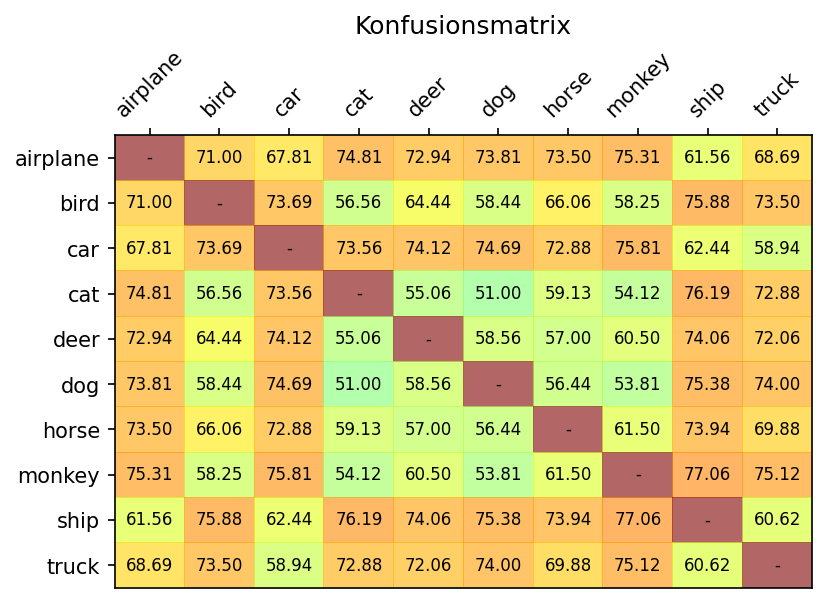

In [7]:
r = np.zeros((10, 10))
for c1 in range(10):
    for c2 in range(10):
        test_classes = [classes[c1], classes[c2]]
        test_subset_labels=[]
        train_subset_labels=[]
        test_index=[]
        train_index=[]
        for i , j in enumerate(test_labels):
            if (j.item()==class_id_dict[test_classes[0]]) or (j.item()==class_id_dict[test_classes[1]]):
                test_subset_labels.append(j.item())
                test_index.append(i)
        for i , j in enumerate(train_labels):
            if (j.item()==class_id_dict[test_classes[0]]) or (j.item()==class_id_dict[test_classes[1]]):
                train_subset_labels.append(j.item())
                train_index.append(i)
        test_subset_bof_mat=np.zeros((len(test_subset_labels),vw_count))
        test_subset_bof_mat=test_bof_mat[test_index]
        train_subset_bof_mat=np.zeros((len(train_subset_labels),vw_count))
        train_subset_bof_mat=train_bof_mat[train_index]
        
        neighbours = 5 # represent the number  of our label s
        count = np.zeros(10) 

        distances = cdist(test_subset_bof_mat  , train_subset_bof_mat ) 

        sort_ids = np.argsort(distances)
        #print(sort_ids)
        calculated_labels=np.zeros(len(sort_ids))
        #print(len(sort_ids))
        for i in range(len(sort_ids)):
            for j in range(neighbours):
                count[train_subset_labels[sort_ids[i,:neighbours][j]]]+=1
            #print("count",count)
            #print(np.argsort(count)[1])
            calculated_labels[i]=np.argsort(count)[9]
            count = np.zeros(10)

        r[c1][c2] = accuracy_score(test_subset_labels,calculated_labels)*100

        



draw_confusion_mat(r, class_labels=classes)